# Task 3: Toxic Comment Analysis

## Introduction:
- Toxic comment can be found almost everywhere on the internet and it makes a negative impact to people reading it. In this post, we will build a multi-label model that’s capable of detecting different types of toxicity like severe toxic, threats, obscenity, insults. The dataset can be found on Kaggle.

## Preparation:
- Things we need for this post:

In [64]:
import pandas as pd
import numpy as np

#nlp
import re
import spacy

#plotting and other tools
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

#stop words list
from my_stop_words import STOP_WORDS
from toxic_words import TOXIC_WORDS


#sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')




### Loading Spacy language package and reading dataset

In [2]:
nlp = spacy.load('en')

In [47]:
df = pd.read_csv('./Data/train.csv').drop('id', axis=1)
df.head()

comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0

In [49]:
df_toxic = df.drop('comment_text', axis=1).copy()
df_text = df['comment_text'].copy()

In [53]:
print('Number of comment: {}'.format(len(df_text)))

Number of comment: 159571


- So here we got 159571 comments and six type of labels: toxic, server_toxic, obscene, insult, identity_hate

# Part 1: Basic analysis:

### Counting the number of each label

In [98]:
counter = df_toxic.apply(pd.value_counts).loc[1].sort_values()

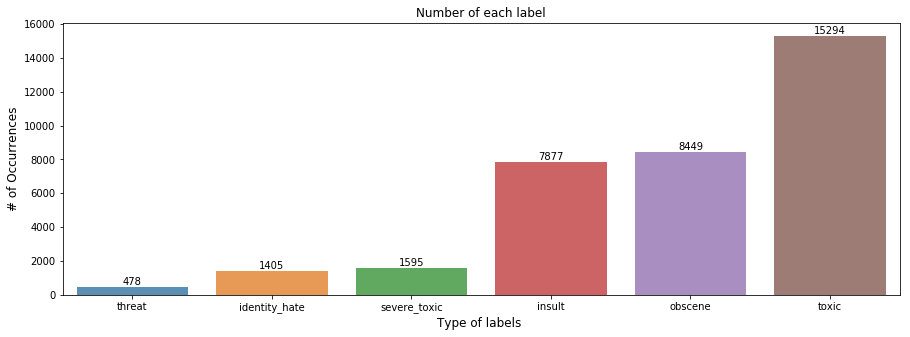

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
Name: 1, dtype: int64


In [101]:
plt.figure(figsize=(15,5))
ax = sns.barplot(counter.index, counter.values, alpha=0.8)
plt.title('Number of each label')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type of labels ', fontsize=12)

rects = ax.patches
labels = counter.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print(counter)

- We can see that the majority is toxic label and threat label is the lowest

### Counting the Multiple label per comment

In [61]:
multi_label = df_toxic.sum(axis=1).value_counts()

In [69]:
plt.figure(figsize=(15,5))
ax = sns.barplot(multi_label.index, multi_label.values, alpha=0.8)
plt.title('Multiple label per comment')
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of labels ', fontsize=12)

rects = ax.patches
labels = multi_label.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print(multi_label)

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


- Most of the comment are labeled as clean comment (with no toxic label) and plays about 90% of all te dataset 
- There are only 31 comments that labeled with 6 labels

In [10]:
title = '% of multiple label per comment'
multi_label.plot(kind='pie', title=title, fontsize=13, labels=None, autopct='%1.1f%%',  pctdistance=0.8, figsize=(8,8), legend=True, startangle=60, table=True)


## Length of text

In [71]:
text_lens = df_text.str.len()
text_lens.hist(bins = np.arange(0,5000,50), figsize=(15,5))

- Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long

# Part 2: Data preprocessing:

- Take a look for the raw data that we get

In [105]:
df['comment_text'].head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

- So we need to remove lots of things here. I try to preprocess the data with regex for removing email, ulr, stand along number and letter,.... and use spacy and list of toxic words for removing name entity without removing capital toxic words (spacy assumes all capital word are name entity)

### Cleaning text

In [12]:
def remove_stop_word(data):
    regex_email = re.compile(r'(https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+)|([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)|(\'s|\'S|\'ll|\'LL|\'re|\'RE|\'m|\'M|\'d|\'D|\'ve|\'VE)')
    regex_list1 = re.compile('(?<=[a-zA-z])(n\'t|N\'T)')
    regex_list2 = re.compile('([^a-zA-Z0-9 ])')
    regex_list3 = re.compile('(?<=(\s))[0-9]+(?=(\s+|$))')
    regex_list4 = re.compile('(?<=(\s))[a-zA-Z](?=(\s+|$))')
    regex_list5 = re.compile(r'([a-zA-Z])\1\1+')
    regex_list6 = re.compile('\s\s+')
    
    data = re.sub(regex_email, '',data)
    data = re.sub(regex_list1, ' not', data)
    data = re.sub(regex_list2, ' ', data)
    data = re.sub(regex_list3, '',data)
    data = re.sub(regex_list4, '',data)
    data = re.sub(regex_list5, r'\1', data)
    data = re.sub(regex_list6, ' ',data)
    data = ' '.join([word for word in data.split() if word.lower() not in STOP_WORDS])
    return data

def remove_ents(data):
    tokens = nlp(data)
    result = ''
    for each in tokens:
        if(each.ent_type_ == '' or each.lemma_ in TOXIC_WORDS):
            result += ' ' + each.lemma_
    return result

#using 'join'
# def remove_ents3(data):
#     tokens = nlp(data)
#     return ' '.join([each.lemma_ for each in tokens if (each.ent_type_ == '' or each.lemma_ in TOXIC_WORDS)])

def clean_text(data):
    return remove_ents(remove_stop_word(data))



```python
TEXT = df_text.map(lambda x: clean_text(x))
TEXT.to_csv('clean_text.csv')
%store TEXT
```

### Splitting to train-test set

- Filling all NaN row with empty string so that we can get the feature without error.
- Here I use 70% of the data for training purpose and the 30% for validating

In [14]:
df['comment_text'] = TEXT.fillna('')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=0, test_size=0.3, shuffle=False)

x_train = train.comment_text.reset_index(drop=True)
x_test = test.comment_text.reset_index(drop=True)
y_train = train[labels].reset_index(drop=True)
y_test = test[labels].reset_index(drop=True)

# Part 3: Feature engineering:

### 3.1 Spacy sentence vectors: 

In [15]:
def cal_sentence_vector(data):
    dimension = len(nlp(data.loc[0]).vector)
    result = np.zeros([len(data), dimension])
    for index in range(0, len(data)):
        print(index)
        t = data.loc[index]
        if(t != ''):
            tokens = nlp(t)
            result[index] = tokens.vector
    return result

```python
x_train_spacy = cal_sentence_vector(x_train)
x_test_spacy = cal_sentence_vector(x_test)
%store x_train_spacy
%store x_test_spacy
```

### 3.2 Bag-of-words:

In [17]:
bow = CountVectorizer()
bow.fit(TEXT)

x_train_bow = bow.transform(x_train)
x_test_bow = bow.transform(x_test)

### 3.3 TF-IDF

In [18]:
tfidf = TfidfVectorizer()
tfidf.fit(TEXT)

x_train_tfidf = tfidf.transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

# Part 4: Bulding models, training and testing:

- I use 4 methods : ___MULTINOMIAL NAIVE BAYES, LOGISTIC REGRESSION, RANDOM FOREST CLASSIFIER, LINEAR SVM___
- I have tried with the ___KNN CLASSIFIER___ but it stuck everytime I train, so I will temporarily remove it out of this post.
- The ___MULTINOMIAL NAIVE BAYES___ only works with positive feature vector, so Spacy sentence vector cannot work with this method, only Bag of word and Tf-idf feature vector can.

In [19]:
logistic_pipeline = Pipeline([('train', LogisticRegression(random_state=0))])
rand_forest_pipeline = Pipeline([('train', RandomForestClassifier(random_state=0))])
knn_pipeline = Pipeline([('train', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2))])
multinomial_naive_bayes_pipeline = Pipeline([('train', MultinomialNB(fit_prior=True, class_prior=None))])
#gaussian_bayes_pipeline = Pipeline([('train', GaussianNB())])
linear_svm_pipeline = Pipeline([('train', LinearSVC())])


In [20]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
feature_engineering = {
    'Spacy': [x_train_spacy, x_test_spacy],
    'Bag-of-words': [x_train_bow, x_test_bow],
    'Tf-idf': [x_train_tfidf, x_test_tfidf]
}

methods = {
    'MULTINOMIAL NAIVE BAYES': multinomial_naive_bayes_pipeline,
    'LOGISTIC REGRESSION': logistic_pipeline,
    'RANDOM FOREST CLASSIFIER': rand_forest_pipeline,
    'LINEAR SVM': linear_svm_pipeline
    #'KERNEL SVM': kernel_svm_pipeline,
    #'KNN CLASSIFIER': knn_pipeline
    #'GAUSSIAN NAIVE BAYES': gaussian_bayes_pipeline,
}


### Trainning and testing:

In [21]:
time_execution_dict = {
    'Spacy' : [[] for each in methods],
    'Bag-of-words' : [[] for each in methods],
    'Tf-idf' : [[] for each in methods]
}

f1_score_dict = {
    'Spacy' : [[] for each in methods],
    'Bag-of-words' : [[] for each in methods],
    'Tf-idf' : [[] for each in methods]
}

accuracy_dict = {
    'Spacy' : [[] for each in methods],
    'Bag-of-words' : [[] for each in methods],
    'Tf-idf' : [[] for each in methods]
}


# 1st for loop is methods, 2nd is
for index, classifier in enumerate(methods.items()):
    print('________ {} ________'.format(classifier[0]))
    for feature, vectors in feature_engineering.items():
        print('\n  * Feature Engineering method: {}'.format(feature))
        if classifier[0] == 'MULTINOMIAL NAIVE BAYES' and feature == 'Spacy':        
            for label in labels:
                time_execution_dict[feature][index].append(0)
                f1_score_dict[feature][index].append(0)
                accuracy_dict[feature][index].append(0)
        else:
            for label in labels:
                print('...Processing {}'.format(label))
                t1 = timer()
                classifier[1].fit(vectors[0], y_train[label])
                y_pred = classifier[1].predict(vectors[1])
                t2 = timer()
                accuracy = metrics.accuracy_score(y_test[label], y_pred)
                f1_score = metrics.f1_score(y_test[label], y_pred, average='macro')
                print('--> Time Execution: %.3f' % (t2 - t1))
                print('--> Test Accuracy: %.6f' % accuracy)
                print('--> F1 Score: %.6f' % f1_score)

                time_execution_dict[feature][index].append(t2 - t1)
                f1_score_dict[feature][index].append(f1_score)
                accuracy_dict[feature][index].append(accuracy)
            
        print('----------------------------')
    print('>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<\n')


________ MULTINOMIAL NAIVE BAYES ________

  * Feature Engineering method: Spacy
----------------------------

  * Feature Engineering method: Bag-of-words
...Processing toxic
--> Time Execution: 0.110
--> Test Accuracy: 0.943328
--> F1 Score: 0.824210
...Processing severe_toxic
--> Time Execution: 0.108
--> Test Accuracy: 0.984876
--> F1 Score: 0.691970
...Processing obscene
--> Time Execution: 0.100
--> Test Accuracy: 0.963549
--> F1 Score: 0.816819
...Processing threat
--> Time Execution: 0.105
--> Test Accuracy: 0.994172
--> F1 Score: 0.519157
...Processing insult
--> Time Execution: 0.111
--> Test Accuracy: 0.959287
--> F1 Score: 0.775747
...Processing identity_hate
--> Time Execution: 0.106
--> Test Accuracy: 0.985440
--> F1 Score: 0.593437
----------------------------

  * Feature Engineering method: Tf-idf
...Processing toxic
--> Time Execution: 0.096
--> Test Accuracy: 0.925531
--> F1 Score: 0.663332
...Processing severe_toxic
--> Time Execution: 0.088
--> Test Accuracy: 0.989

%store time_execution_dict
%store f1_score_dict
%store accuracy_dict

In [84]:
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
methods = ['MULTINOMIAL NAIVE BAYES', 'LOGISTIC REGRESSION', 'RANDOM FOREST CLASSIFIER', 'LINEAR SVM']

def plotting(dictionary, feature_method, title):
    plt.subplots(figsize=(20,10))
    bars = []
    barWidth = 0.15
    num_method = len(dictionary[feature_method])
    # set height of bar
    for index in range(0, num_method):
        bars.append(dictionary[feature_method][index])

    # Set position of bar on X axis
    r = [np.arange(len(bars[0]))]
    for index in range(1, num_method):
        r.append([x + barWidth for x in r[index-1]])

    # Make the plot
    for index in range(0, num_method):
        plt.bar(x=r[index], height=bars[index], width=barWidth, edgecolor='white', label=methods[index])

    # Add xticks on the middle of the group bars
    plt.xlabel('Toxic Type', fontweight='bold')
    plt.xticks([r + barWidth*2 for r in range(len(bars[0]))], toxic_labels, fontsize = 15)

    # Create legend, Title & Show graphic
    plt.title(title, size=18)
    plt.legend()
    plt.show()


# Part 5: Result and Conclusion:

## 5.1. F1 Score:

### Spacy:

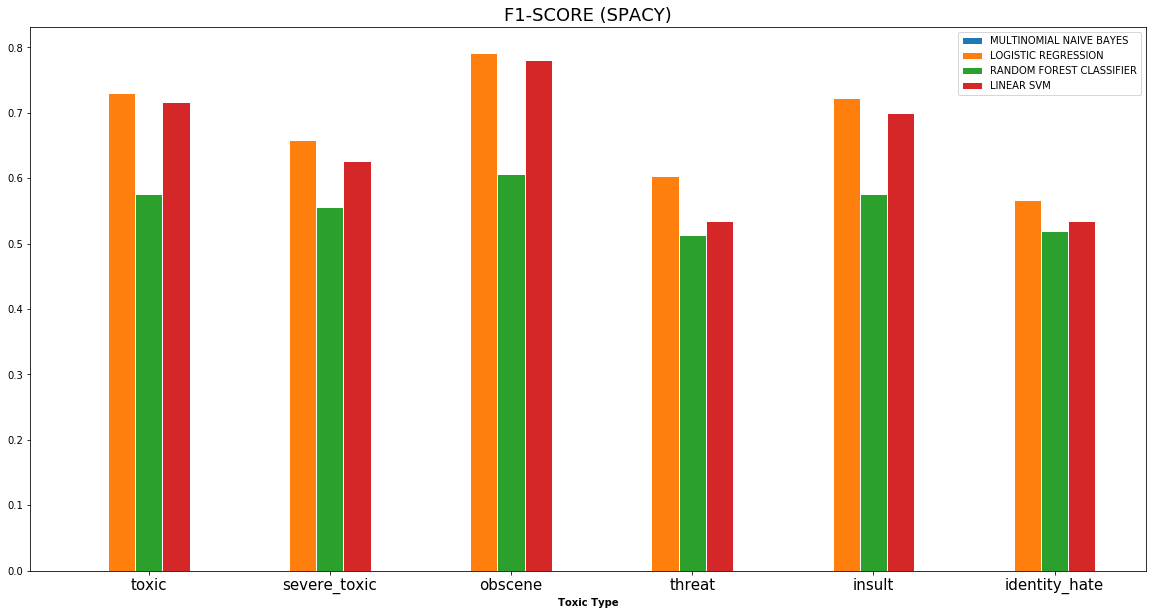

In [44]:
plotting(f1_score_dict, 'Spacy', 'F1-SCORE (SPACY)')

- Using ___Spacy___ sentence vector , ___LOGISTIC REGRESSION___ and ___LINEAR SVM___ give a higest f1 score (> 0.6) and work well with the ___obscene label___ (upto 0.8)

## Bag of Words:

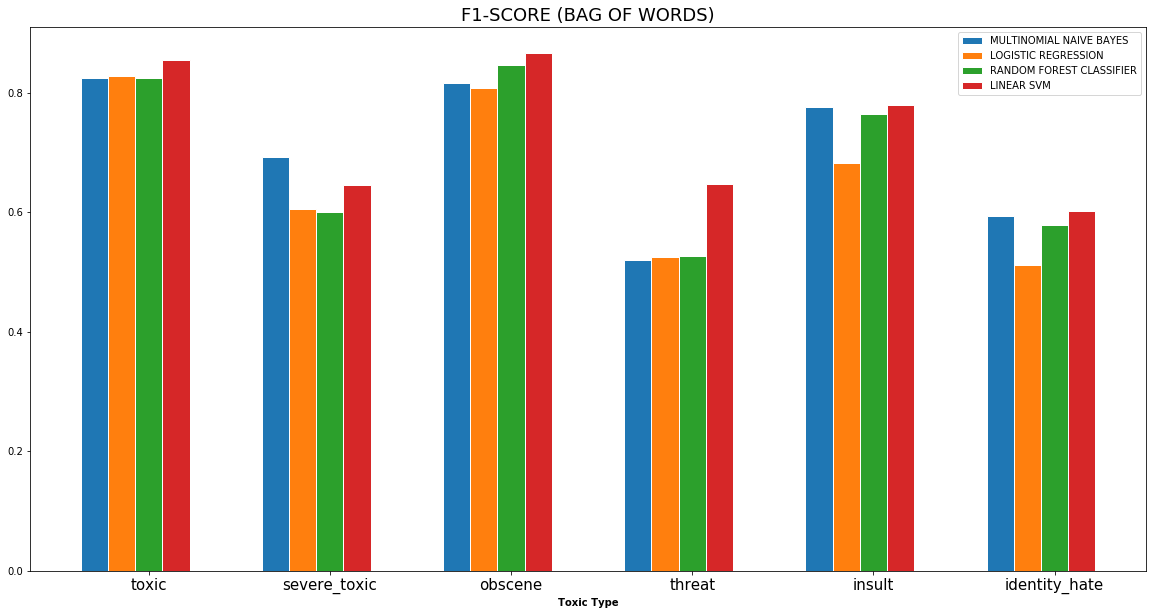

In [24]:
plotting(f1_score_dict, 'Bag-of-words', 'F1-SCORE (BAG OF WORDS)')

Using ___BoW___ feature engineer give also a high results with all four methods and work well with __toxic__ , __obscene__ , ___insult___ labels (> 0.8)

## TF-idf

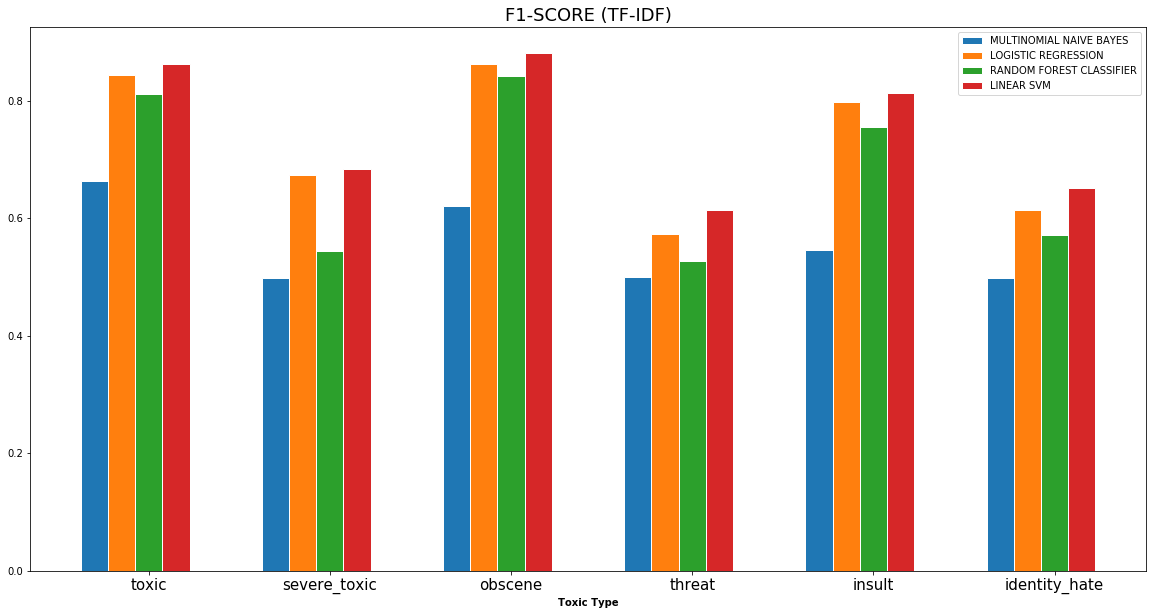

In [25]:
plotting(f1_score_dict, 'Tf-idf', 'F1-SCORE (TF-IDF)')

Using ___Tf-idf___ feature engineer give also a high results with ___LOGISTIC REGRESSION___, ___RANDOM FOREST CLASSIFIER___, ___LINEAR SVM___ methods and work well with __toxic__ , __obscene__ , ___insult___ labels (> 0.8)

## 5.2. Time execution:

###      1.Spacy

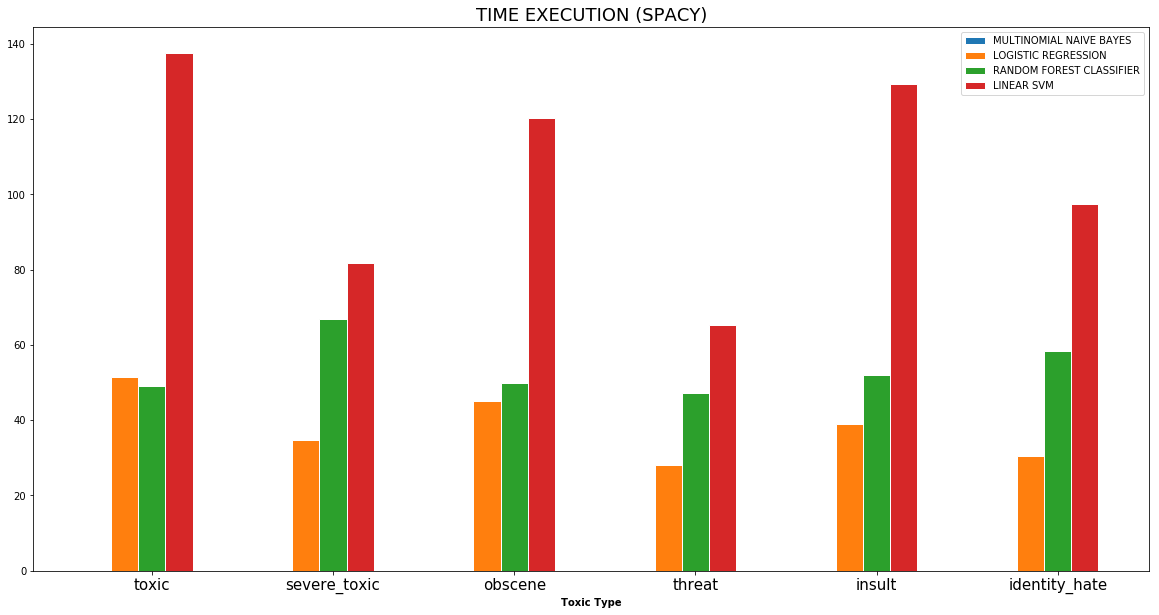

In [26]:
plotting(time_execution_dict, 'Spacy', 'TIME EXECUTION (SPACY)')

- ___LINEAR SVM___ takes the longest time for trainning

## Bag of Words

In [27]:
plotting(time_execution_dict, 'Bag-of-words', 'TIME EXECUTION (BAG OF WORDS)')

## Tf-idf

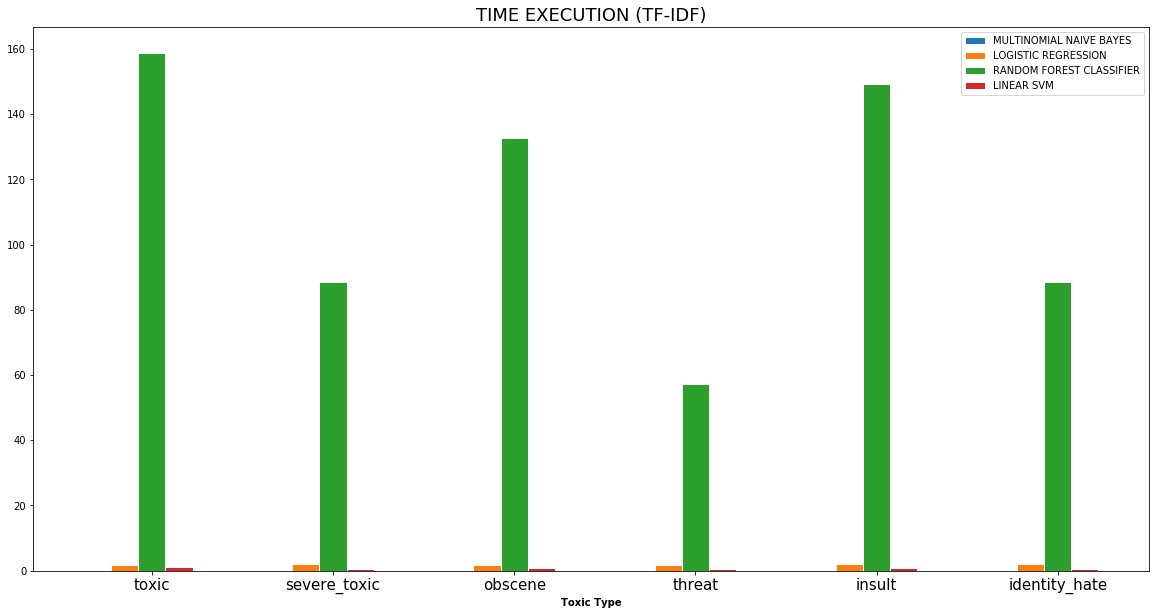

In [28]:
plotting(time_execution_dict, 'Tf-idf', 'TIME EXECUTION (TF-IDF)')

## 5.3. Accuracy

- All 3 feature engineering methods give a high accuracy rate (one of the factors is a high rate of clean comment )

## Spacy

In [29]:
plotting(accuracy_dict, 'Spacy', 'ACCURACY (SPACY)')

## Bag of Words

In [30]:
plotting(accuracy_dict, 'Bag-of-words', 'ACCURACY (BAG OF WORDS)')

## Tf-idf

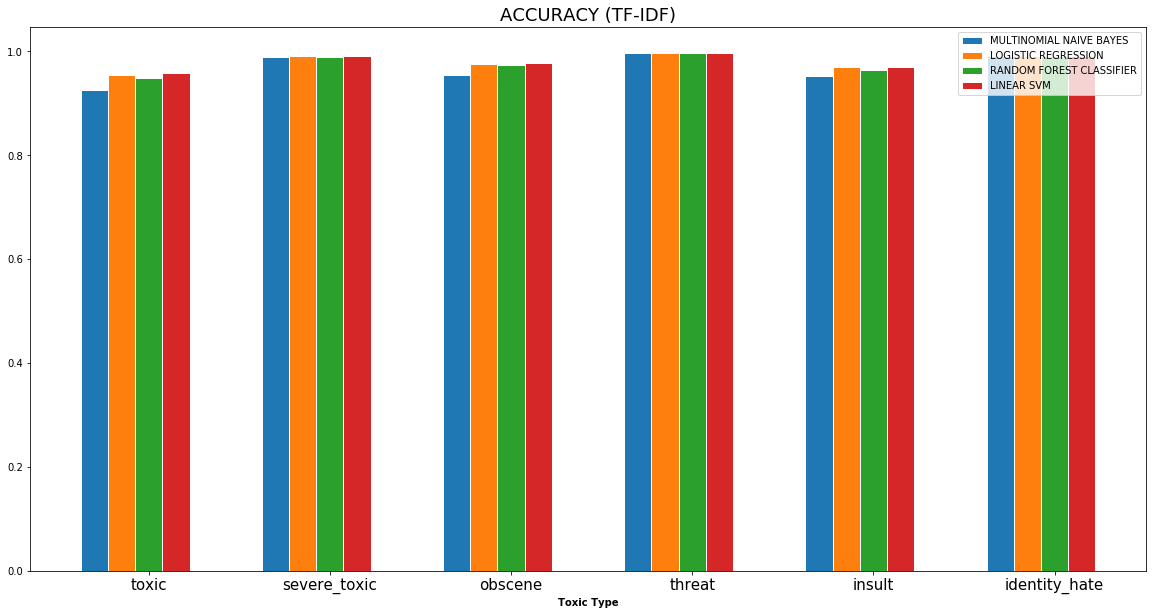

In [31]:
plotting(accuracy_dict, 'Tf-idf', 'ACCURACY (TF-IDF)')

## Conclusion:

- Base on F1 Score, Bag od word and Tfidf give a higher result than Spacy, __LOGISTIC REGRESSIO___ and ___LINEAR SMV__ seem to be the most efficient methods (for high f1 score and low trainning and predicting time)